In [1]:
# %%capture
!pip install matplotlib transformers datasets accelerate sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [16]:
from PIL import Image

# Load an image of a zeolite from a local file
zeolite_path = "/content/zeolite.png"
image = Image.open(zeolite_path).convert("RGB")
caption = "an image of a zeolite"

image.show()


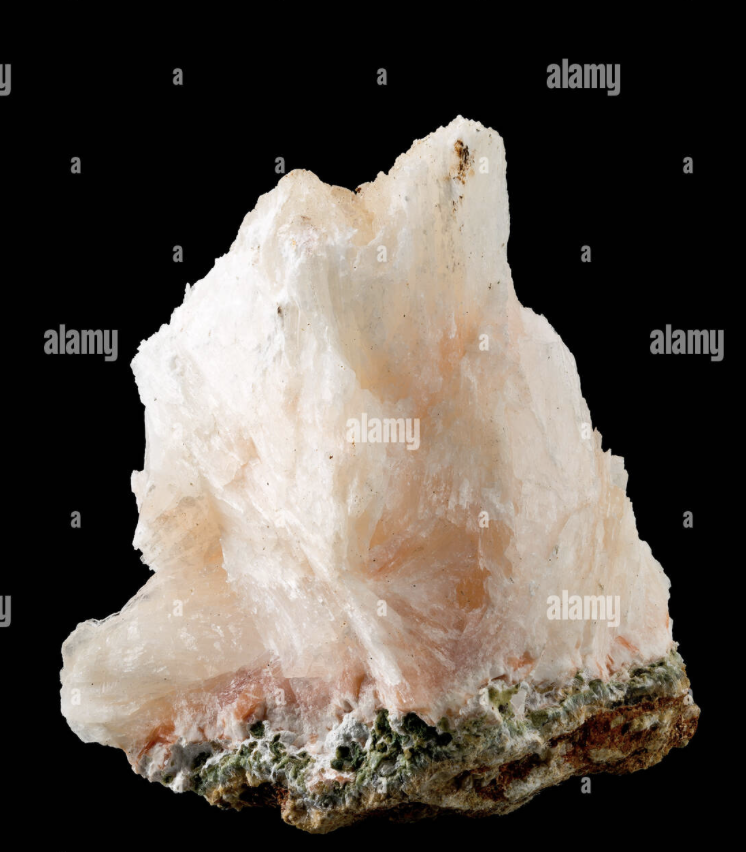

In [17]:
image

### Embeddings

In [20]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

# Load a tokenizer to preprocess the text
clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)

# Load a processor to preprocess the images
clip_processor = CLIPProcessor.from_pretrained(model_id)

# Main model for generating text and image embeddings
model = CLIPModel.from_pretrained(model_id)

In [21]:
# Tokenize our input
inputs = clip_tokenizer(caption, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,   550,  2867,   539,   320,  2254,   562,   802, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [22]:
# Convert our input back to tokens
clip_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'an</w>',
 'image</w>',
 'of</w>',
 'a</w>',
 'ze',
 'ol',
 'ite</w>',
 '<|endoftext|>']

In [23]:
# Create a text embedding
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 512])

In [24]:
# Preprocess image
processed_image = clip_processor(
    text=None, images=image, return_tensors='pt'
)['pixel_values']

processed_image.shape

torch.Size([1, 3, 224, 224])

(-0.5, 223.5, 223.5, -0.5)

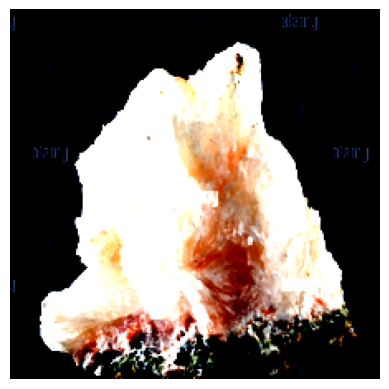

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Prepare image for visualization
img = processed_image.squeeze(0)
img = img.permute(*torch.arange(img.ndim - 1, -1, -1))
img = np.einsum('ijk->jik', img)

# Visualize preprocessed image
plt.imshow(img)
plt.axis('off')

In [26]:
# Create the image embedding
image_embedding = model.get_image_features(processed_image)
image_embedding.shape

torch.Size([1, 512])

In [27]:
# Normalize the embeddings
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

# Calculate their cosine similarity
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()
score = text_embedding @ image_embedding.T
score

array([[0.3119452]], dtype=float32)

### More Images

In [35]:
from PIL import Image
import numpy as np

# Define file paths
earth_path = "/content/earth.png"
hearth_path = "/content/heart.png"
turkey_path = "/content/turkey.png"
paths = [earth_path, hearth_path, turkey_path]

# Load images
images = [Image.open(path).convert("RGB") for path in paths]

# Define captions
captions = [
    "image of earth",
    "image of heart",
    "image of turkey"
]

# Embed all images
image_embeddings = []
for image in images:
    # Process each image for the CLIP model
    image_processed = clip_processor(images=image, return_tensors="pt")["pixel_values"]
    image_embedding = model.get_image_features(image_processed).detach().cpu().numpy()[0]
    image_embeddings.append(image_embedding)
image_embeddings = np.array(image_embeddings)

# Embed all captions
text_embeddings = []
for caption in captions:
    # Tokenize each caption for the CLIP model
    inputs = clip_tokenizer(caption, return_tensors="pt")
    text_emb = model.get_text_features(**inputs).detach().cpu().numpy()[0]
    text_embeddings.append(text_emb)
text_embeddings = np.array(text_embeddings)


In [36]:
# Calculate cosine similarity between images and captions
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(image_embeddings, text_embeddings)

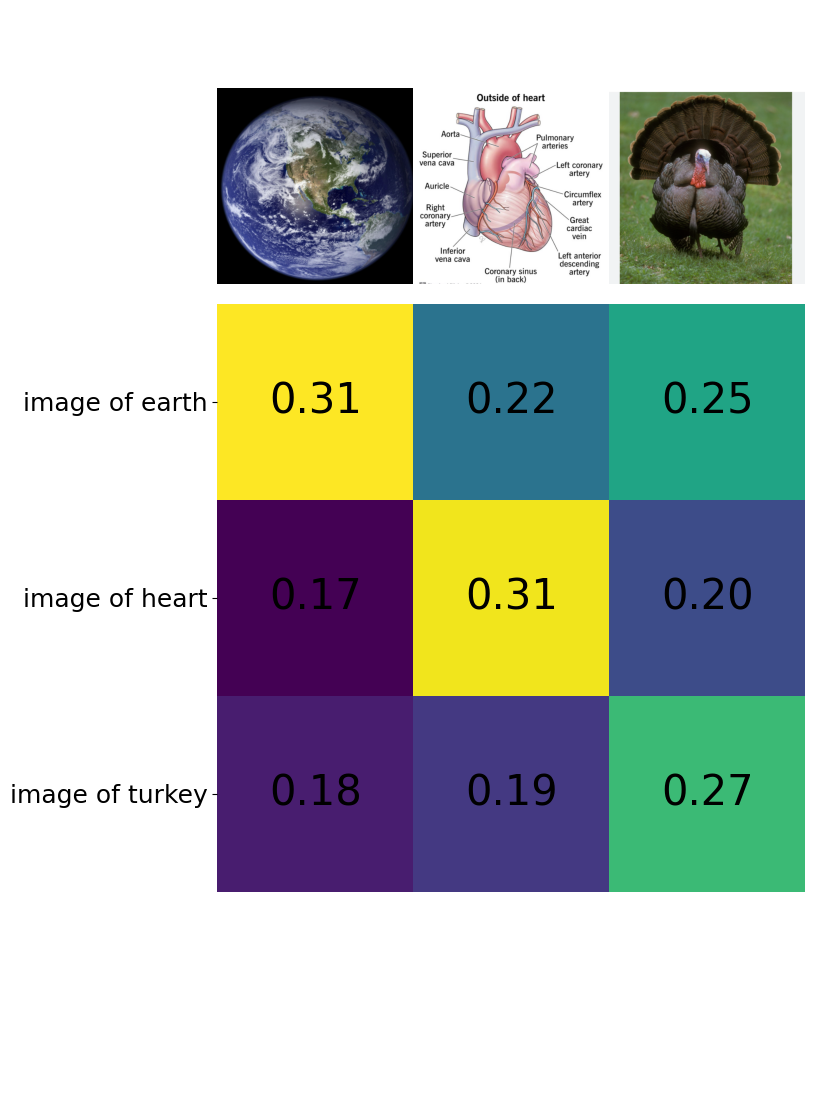

In [37]:
# Create base figure
plt.figure(figsize=(20, 14))
plt.imshow(sim_matrix, cmap='viridis')

# Adjust ticks with correct labels
plt.yticks(range(len(captions)), captions, fontsize=18)
plt.xticks([])

# Visualize
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# Add the captions at the correct indices
for x in range(sim_matrix.shape[1]):
    for y in range(sim_matrix.shape[0]):
        plt.text(x, y, f"{sim_matrix[y, x]:.2f}", ha="center", va="center", size=30)

# Remove unnecessary spines
for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

# Resize blocks
plt.xlim([-0.5, len(captions) - 0.5])
plt.ylim([len(captions) + 0.5, -2])
# plt.title("Similarity Matrix", size=20)
plt.savefig("sim_matrix.png", dpi=300, bbox_inches='tight')